# VAE - Solordinario


In [ ]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
latent_dims = 64
num_epochs = 3000
batch_size = 25
capacity = 2
learning_rate = 5e-4
variational_beta = 5e-3
coefPitch=10.
coefLoudness=1.

# Chargement des données 


In [6]:
import os
import descriptors
import numpy as np

use_homemade_dataset = False

dict_r1 = np.load('data_dict.npy', allow_pickle=True).item()
train_db1 = np.zeros([len(dict_r1['env']),2,750])
i = 0
for sample in dict_r1['env']:
    train_db1[i,:,:] = sample
    i+=1

if use_homemade_dataset == True:
    dict_r2 = np.load('data_dict_jerem_v1.npy', allow_pickle=True).item()
    train_db2 = np.zeros([len(dict_r2['env']),2,750])
    i = 0
    for sample in dict_r2['env']:
        train_db2[i,:,:] = sample
        i+=1
        
    train_db = np.concatenate((train_db1, train_db2)) 
#
 
if use_homemade_dataset == False:
    train_db = train_db1

nb_files, nb_can, nb_samples = np.shape(train_db)

pitches = np.mean(train_db[:,1,:], axis=1)
pitches = np.expand_dims(pitches, axis=1)
pitches = np.broadcast_to(pitches,(nb_files,750))

train_db[:,1,:] = train_db[:,1,:]/pitches[:] #on retire le pitch

MAX1 = np.max(np.abs(train_db[:,0,:]))
MAX2 = np.max(np.abs(train_db[:,1,:]))
train_db[:,0,:] /= MAX1
train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

# Defintion du AE 

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity     
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=c, kernel_size=10, stride=2, padding=2), nn.BatchNorm1d(c)) # out: c, 372
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c*4, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*8, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.lin1 = nn.Linear(8*c*47, latent_dims*8)
        self.lin2 = nn.Linear(latent_dims*8, latent_dims*4)
        self.fc_mu = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=latent_dims*4)
        self.lin2 = nn.Linear(latent_dims*4, latent_dims*8)
        self.lin3 = nn.Linear(latent_dims*8, 8*c*47)
        self.lin4 = nn.Linear(in_features=750, out_features=750)
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c))
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*4, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*2, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=2, kernel_size=10, stride=1, padding=4)) # out: c, 372
        self.conv6 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=2, kernel_size=10, stride=1, padding=4)) # out: c, 372
        self.upsample1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.upsamplef = nn.Upsample(size=752, mode="nearest")

            
    def forward(self, x):
        x = F.relu(self.fc(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = x.view(x.size(0), capacity*8, 47) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1(x))
        x = self.upsample1(x)
        x = F.relu(self.conv2(x))
        x = self.upsample1(x)
        x = F.relu(self.conv3(x))
        x = self.upsample1(x)
        x = F.relu(self.conv4(x))
        x = self.upsamplef(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.sigmoid(self.lin4(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
        
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = (coefLoudness*F.mse_loss(recon_x[:,0,:], x[:,0,:], reduction='sum')+coefPitch*F.mse_loss(recon_x[:,1,:], x[:,1,:], reduction='sum'))/np.size(batch_size)
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/np.size(batch_size)  
    return recon_loss + variational_beta * kldivergence, recon_loss, variational_beta * kldivergence
    
vae = VariationalAutoencoder()

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1651602


# Entrainement

In [6]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []
train_loss_avg2 = []
train_loss_avg3 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    train_loss_avg2.append(0)
    train_loss_avg3.append(0)
    num_batches = 0
    
    for image_batch in train_loader:

        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0])
        image_batch = image_batch.view(batch_size,2,750)
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch.float())
        
        # reconstruction error
        loss, loss2, loss3 = vae_loss(image_batch_recon, image_batch.float(), latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        train_loss_avg2[-1] += loss2.item()
        train_loss_avg3[-1] += loss3.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    train_loss_avg2[-1] /= num_batches
    train_loss_avg3[-1] /= num_batches
    
    if epoch%20 == 19:
        print('Epoch [%d / %d] average reconstruction error: %f (l2 = %f, l3 = %f)' % (epoch+1, num_epochs, train_loss_avg[-1], train_loss_avg2[-1], train_loss_avg3[-1]))

Training ...
Epoch [20 / 3000] average reconstruction error: 164.454128 (l2 = 158.626905, l3 = 5.827222)
Epoch [40 / 3000] average reconstruction error: 130.381716 (l2 = 126.125143, l3 = 4.256576)
Epoch [60 / 3000] average reconstruction error: 105.957217 (l2 = 102.196242, l3 = 3.760975)
Epoch [80 / 3000] average reconstruction error: 85.233361 (l2 = 82.124892, l3 = 3.108469)
Epoch [100 / 3000] average reconstruction error: 63.653515 (l2 = 60.108910, l3 = 3.544605)
Epoch [120 / 3000] average reconstruction error: 62.087748 (l2 = 58.775167, l3 = 3.312580)
Epoch [140 / 3000] average reconstruction error: 59.413044 (l2 = 56.261288, l3 = 3.151757)
Epoch [160 / 3000] average reconstruction error: 58.860077 (l2 = 55.864484, l3 = 2.995592)
Epoch [180 / 3000] average reconstruction error: 59.558659 (l2 = 56.608083, l3 = 2.950576)
Epoch [200 / 3000] average reconstruction error: 60.411201 (l2 = 57.480630, l3 = 2.930571)
Epoch [220 / 3000] average reconstruction error: 59.695510 (l2 = 56.865695,

# Affichage de la courbe de loss 

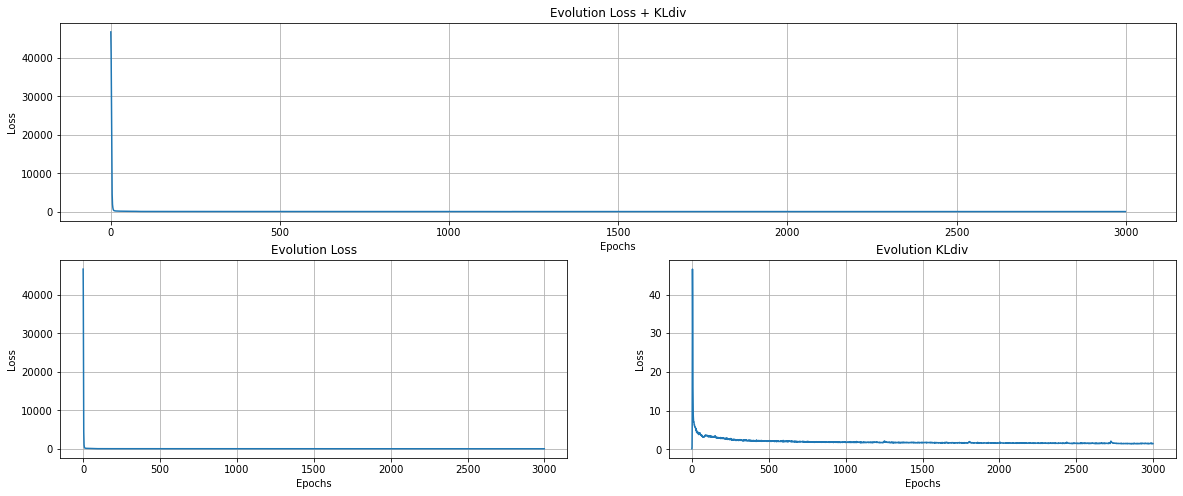

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(20,8))
plt.subplot(211)
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution Loss + KLdiv')
plt.grid()
plt.subplot(223)
plt.plot(train_loss_avg2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution Loss')
plt.grid()
plt.subplot(224)
plt.plot(train_loss_avg3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution KLdiv')
plt.grid()
plt.show()

In [ ]:
#Sauvergarder valeurs de l'entrainement
#torch.save(vae.state_dict(), 'vaeMODELtrained2')

# Reconstruction 

In [8]:
#Load des valeurs de modèles pré-entrainé
vae.load_state_dict(torch.load('vaeMODELtrained2'))

<All keys matched successfully>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction

index_list = [10,20,30,40,50,60]
index_list = list(range(12))

list_sources = [[train_db[i,0,:]*MAX1,train_db[i,1,:]*pitches[i]] for i in index_list]

list_images = []
for i in index_list:
    images = train_db[i,:,:]
    images_recon,_,_ = vae(torch.from_numpy(images).view(1,2,750).float())
    images_recon = images_recon.detach().numpy()
    list_images.append([images_recon[0,0,:]*MAX1,(images_recon[0,1,:]*(pitches[i]))])


## Visualisation : 

In [13]:
from visualizer import Visualizer
V = Visualizer(list_images,list_sources) 

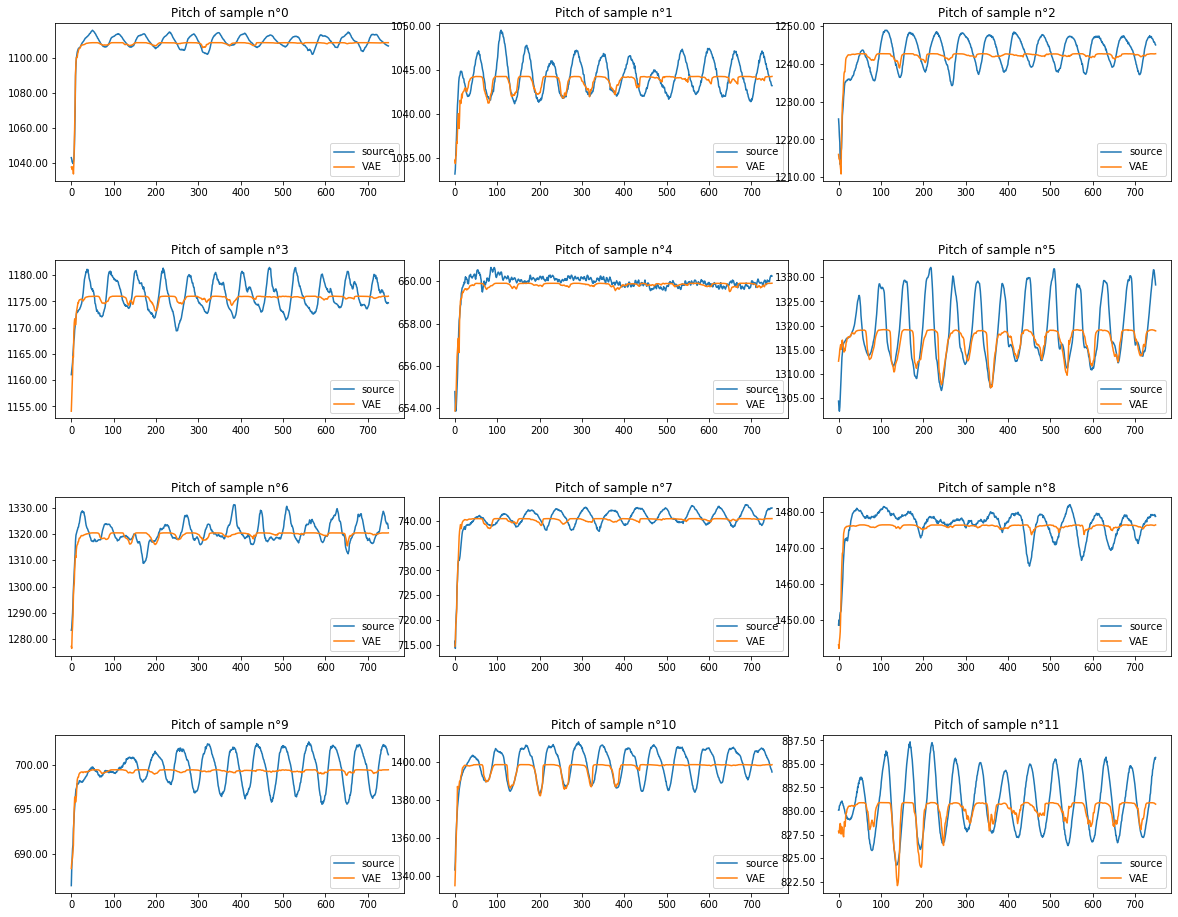

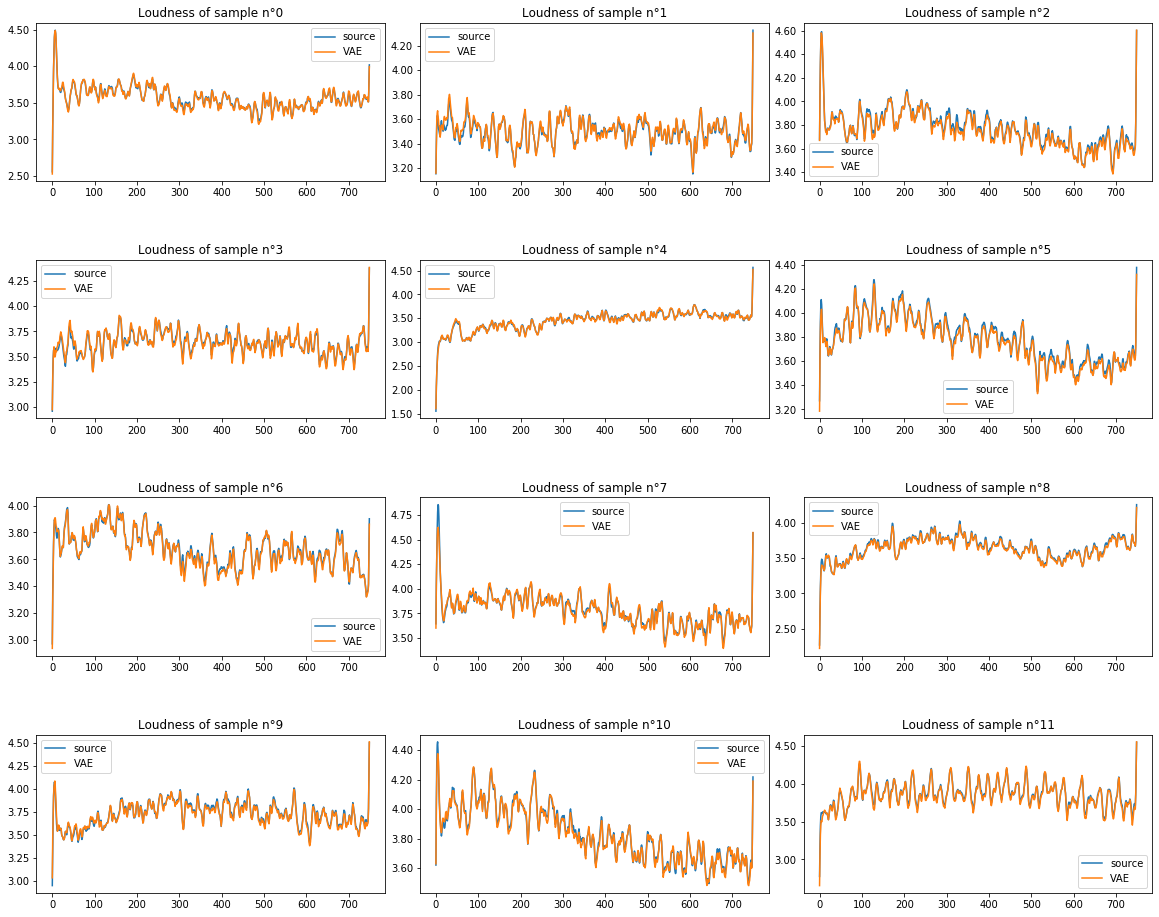

In [14]:
V.show_pitch()
V.show_loudness()

### DDSP pour écouter résultats

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


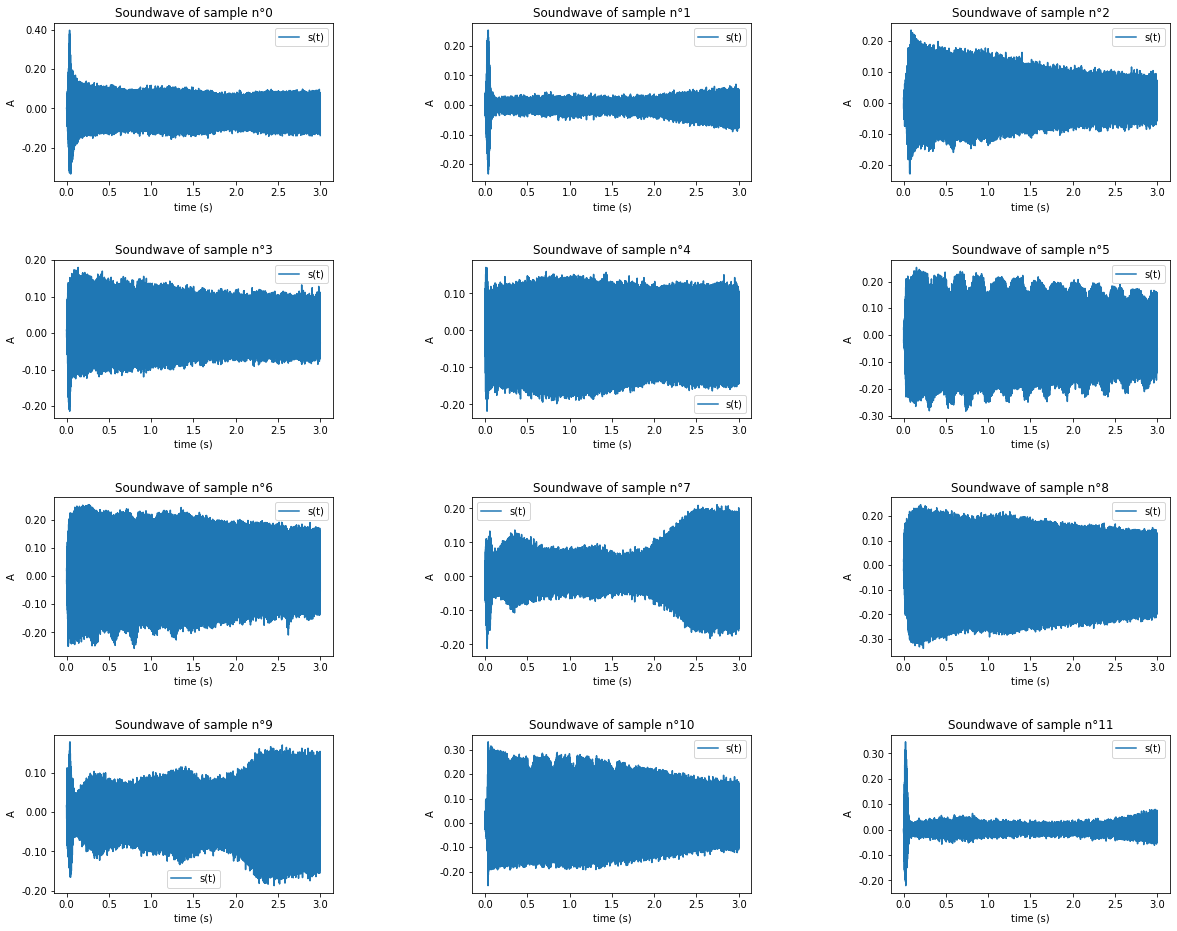

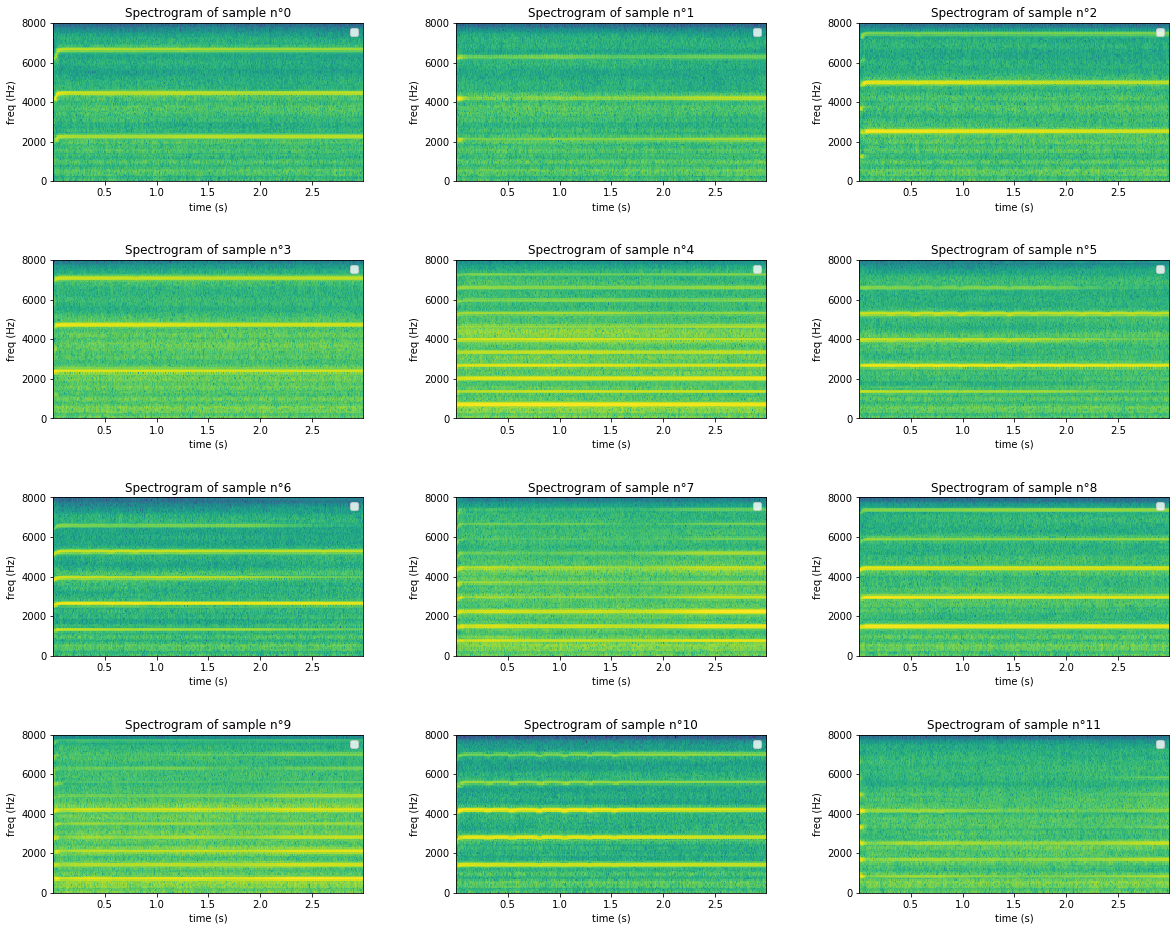

In [15]:
ddsp = torch.jit.load('ddsp_solordinario_pretrained.ts')
V.reconstruction(ddsp)
V.show_sound()
V.show_spectrogramm()

## Écoute des sons obtenus : 

In [16]:
V.listen(5)